Candidates: 265

First we start by importing all necessary libraries. Json is a built-in Python module that provides methods for working with JavaScript Object Notation data. It allows you to encode Python objects into JSON strings, and thereon decode JSON strings into Python objects. Pandas on the other hand, is a data manipulation library in Python that provides data structures and functions for working with tabular data.

Spacy is a natural language processing library in Python that among others provides tools for tokenization, part-of-speech tagging, dependency parsing, and named entity recognition. We used it because our text is in Norwegian, and this particular library is able to recognize Norwegian texts. Stopwords had to be imported from the Norwegian library - these are a set of common words that are usually removed from text before analysis.

SnowballStemmer is a stemming algorithm that reduces words to their base or root form. It is a part of the nltk library. Tensorflow is a popular open-source machine learning library for building and training deep neural networks.

CountVectorizer is a tool for converting a collection of text documents into a matrix of token counts, where each row represents a document and each column represents a unique word in the corpus. Counter then provides a convenient way to count and keep track of words. 

In [373]:
import json
import pandas as pd
import plotly.graph_objs as go

#Used for counting words 
from collections import Counter
import plotly.graph_objs as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import json
import pandas as pd

#Importing stopwords for the norwegian language
import spacy
from spacy.lang.nb.stop_words import STOP_WORDS

#Importing snowball to do stemming of our text
from nltk.stem.snowball import SnowballStemmer


#Model 
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.layers import Dense
from torch.utils.data import *
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# 1. Data preparation

In [374]:
data = {name: json.load(open(f"3class/{name}.json")) for name in ["dev", "test", "train"]}
data

{'dev': [{'sent_id': '108886-01-01',
   'text': '« Firework »',
   'label': 'Neutral'},
  {'sent_id': '108886-02-01',
   'text': 'Hun avslutter , lurt nok , med sin aller største hit .',
   'label': 'Positive'},
  {'sent_id': '108886-02-04',
   'text': 'Og jada , vi får servert fyrverkeri også , før Perry går inn i prismen hun kom ut av til å begynne med .',
   'label': 'Neutral'},
  {'sent_id': '500236-01-01',
   'text': 'Unyansert om slaveriet',
   'label': 'Negative'},
  {'sent_id': '500236-03-01',
   'text': 'Det aller første dansk-norske slaveskipet seilte for en kjøpmann fra Bergen .',
   'label': 'Neutral'},
  {'sent_id': '500236-03-02',
   'text': 'Rundt 100.000 afrikanske slaver ble fraktet over Atlanterhavet på dansk-norske skip før Danmark la ned forbud mot slavehandel , i 1792 , som første land i verden .',
   'label': 'Neutral'},
  {'sent_id': '500236-04-01',
   'text': 'En del av slavene ble solgt via de danske handelsfortene i Vest-Afrika .',
   'label': 'Neutral'},
  {'

We will firstly load all of the files necessary

We have opted to title our data data_train, data_test, and data_dev as opposed to using data['train'], data['test'], and data['dev']. While doing this, we utilized the pandas Dataframe, a two-dimensional labeled structure with potentially varying column types. This approach enabled us to create data_train, which incorporates the data from data['train'] while also designating two columns as ['text'] and ['label']. The same approach was applied to data_test, which will not be utilized until the completion of the task, and data_dev, the validation data that will be used during model training.

In [375]:
data_train = pd.DataFrame(data["train"], columns=["text", "label"])
data_test = pd.DataFrame(data["test"], columns=["text", "label"])
data_dev = pd.DataFrame(data["dev"], columns=["text", "label"])

To then obtain the dimensions of the current data structure, we use the .shape function. This function returns a tuple that represents the dimensions in rows and columns for our dataframe named data_train. 

In [376]:
data_train.shape

(7973, 2)

To obtain the data types of each column in data_train, we used the attribute .dtypes. This attribute returns a pandas Series object with the column names as its index and their corresponding data types as their values. In our case, both columns in data_train have the data type "object", which is what we want.

In [377]:
data_train.dtypes

text     object
label    object
dtype: object

Here we utilized .shape for the observation of data_dev, and as one can see it has 1411 rows and 2 columns.

In [378]:
data_dev.shape

(1411, 2)

We utilized the .dtypes attribute to retrieve the data types of the columns in our data_dev DataFrame. The output reveals that, similar to data_train, both columns have an object data type. This shows that the columns include either strings or a combination of a diverse range of data types.

In [379]:
data_dev.dtypes

text     object
label    object
dtype: object

We use .shape to get the shape of our data_test as well, and in this data it turns out we have 1181 rows, 2 columns.

In [380]:
data_test.shape

(1181, 2)

The .dtypes attribute is utilized to retrieve the data types of the columns in our data_test. We see that both columns contain object data types, showing that the data is a mix of data types/strings.

In [381]:
data_test.dtypes

text     object
label    object
dtype: object

# 2) Missing Values

To check for missing values within the texts, we utilized the .isnull().sum() function in our pandas DataFrame. The .isnull() function looks for missing values in the DataFrame and returns either True or False values. By using the .sum() function after .isnull(), we obtained the total number of True values in the DataFrame, which concurrently showed us the number of missing values. Since the output of .sum() was 0, we can confidently conclude that data_train does not have missing values.

In [382]:
#Missing values
data_train.isnull().sum()

text     0
label    0
dtype: int64

In [383]:
data_dev.isnull().sum()

text     0
label    0
dtype: int64

There are no missing values in data_test, so we can continue the process without needing to perform additional steps.

In [384]:
data_test.isnull().sum()

text     0
label    0
dtype: int64

# 3) Pre-processing

Here, we have used the pandas method .value_counts() to compute the frequency distribution of values in our data_train DataFrame. We are doing this to keep track of the number of times Neutral, Positive, and Negative emotions show up in the data. We see that we have 4079 Neutral, 2624 Positive, and 1270 Negative emotions. We are assigning all of them to "sentiment". We then used the method .plot(kind='bar') to create a bar plot and visualize the distribution of said emotions.

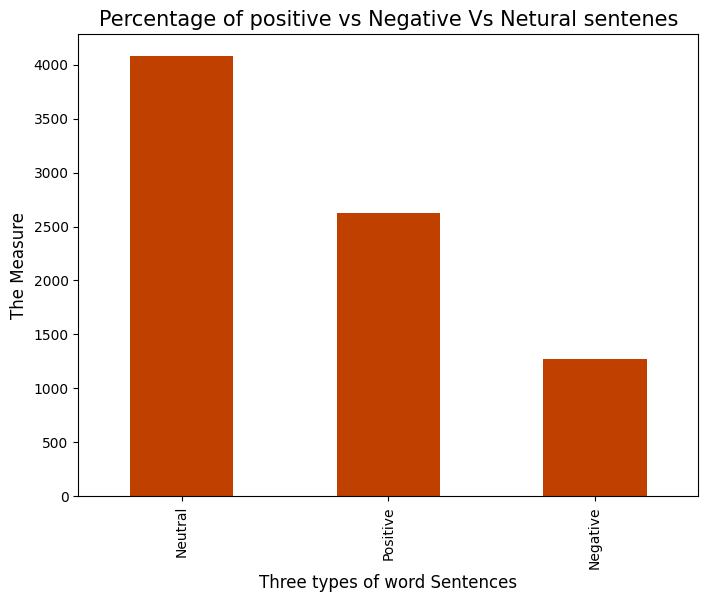

In [385]:
#Counting values within each class
sentiment = data_train["label"].value_counts()

#Defining chart
plt.figure(figsize=(8,6))
sentiment.plot(kind='bar', color = '#C04000')
plt.grid()
plt.xlabel("Three types of word Sentences", fontsize = 12)
plt.ylabel("The Measure", fontsize = 12)
plt.title("Percentage of positive vs Negative Vs Netural sentenes", fontsize = 15)
plt.grid(False)
plt.show()

### 3.1) Spacy

The first line below creates a SnowballStemmer object with the language parameter set to Norwegian. Aforementioned, SnowballStemmer is a stemming library used to transform words to their root form by getting rid of any suffixes and prefixes. The second line here initializes an empty list stem_word that will be used to store the stemmed words. The next three lines iterate over each text in the data_train dataframe, and apply stemming to each word using the SnowballStemmer.stem() method. The stemmed word is then added to the stem_word list. A loop is then used to print each original word and its stemmed version.

In [386]:
#https://www.nltk.org/_modules/nltk/stem/snowball.html


#the stemmer needs a language parameter, in this case the language is norwegian
snow_stemmer = SnowballStemmer(language='norwegian')

#Stemming of each word
stem_word = []
for word in data_train['text']:
    x = snow_stemmer.stem(word)
    stem_word.append(x)

#print stemming results
for e1,e2 in zip(data_train['text'],stem_word):
    print(e1+' ----> '+e2)

Philips 190G6 ----> philips 190g6
Med integrerte høyttalere som på ingen måte er diskret plassert , og med en stor subwoofer inkludert , da snakker vi om en gutteskjerm . ----> med integrerte høyttalere som på ingen måte er diskret plassert , og med en stor subwoofer inkludert , da snakker vi om en gutteskjerm .
Eller bedrar skinnet ? ----> eller bedrar skinnet ?
De fleste skjermer har et diskret design , med smale rammer og slank fot . ----> de fleste skjermer har et diskret design , med smale rammer og slank fot .
Men 190G6 fra Philips er en helt annen historie . ----> men 190g6 fra philips er en helt annen historie .
Den har et utseende som krever oppmerksomhet , med glinsende svart ramme , glansbelegg på skjermflaten og store sølvfargede sidepaneler med fire innfelte høyttalere med svart deksel . ----> den har et utseende som krever oppmerksomhet , med glinsende svart ramme , glansbelegg på skjermflaten og store sølvfargede sidepaneler med fire innfelte høyttalere med svart deksel 

!pip install spacy

I installed the Spacy library to remove Norwegian stop words and punctuations from our data. To achieve this, I imported the STOP_WORDS list from "spacy.lang.nb.stop_words". This list contains Norwegian stop words to be removed. 

In [387]:
# Load the language model
nlp = spacy.load("nb_core_news_sm")
stopwords = list(STOP_WORDS)
stopwords

['ja',
 'gjorde',
 'mål',
 'disse',
 'bedre',
 'som',
 'kommer',
 'ble',
 'dermed',
 'noen',
 'nye',
 'gjør',
 'grunn',
 'vil',
 'laget',
 'der',
 'bris',
 'et',
 'runde',
 'kroner',
 'den',
 'rundt',
 'år',
 'ham',
 'blitt',
 'ny',
 'du',
 'og',
 'dette',
 'andre',
 'kl',
 'man',
 'skal',
 'gang',
 'igjen',
 'men',
 'ingen',
 'får',
 'stedet',
 'tillegg',
 'å',
 'tidligere',
 'se',
 'god',
 'hadde',
 'ifølge',
 'kontakt',
 'først',
 'både',
 'senere',
 'mener',
 'leder',
 'ikke',
 'mange',
 'når',
 'kampen',
 'er',
 'blir',
 'hele',
 'selv',
 'dem',
 'gi',
 'bak',
 'være',
 'til',
 'and',
 'opp',
 'litt',
 'på',
 'så',
 'han',
 'oss',
 'i',
 'siden',
 'uten',
 'over',
 'vi',
 'komme',
 'henne',
 'denne',
 'en',
 'etter',
 'ned',
 'før',
 'mye',
 'gå',
 'svært',
 'fikk',
 'vår',
 'de',
 'godt',
 'blant',
 'helt',
 'få',
 'siste',
 'første',
 'seks',
 'personer',
 'fått',
 'seg',
 'ser',
 'folk',
 'viktig',
 'sier',
 'også',
 'dag',
 'av',
 'tatt',
 'flere',
 'mer',
 'videre',
 'samtidi

### 3.2) Data Cleaning

To scrub the text data in our train test, we must remove Norwegian stop words. To keep the original text, we will create a new column called "cleaned_text" and apply a function that removes stop words and punctuations. This function will remove the stop words and punctuations from the text in data_train, and the cleaned text will be added to the new column. Then, we will apply the cleaned text to our column in data_train. Right after that, we will use snowball to stem the data.

In [388]:
stopwords = nlp.Defaults.stop_words

def delete_stopwords(text):
    file = nlp(text)
    return " ".join([token.lemma_ for token in file if not token.is_stop and not token.is_punct])

data_train['text_cleaning'] = data_train['text'].apply(delete_stopwords)
data_train['text_cleaning']
data_dev['text_cleaning'] = data_dev['text'].apply(delete_stopwords)
data_dev['text_cleaning']

0                                                Firework
1                            avslutte lure aller stor hit
2            jada servere fyrverkeri Perry prisme begynne
3                                       unyansert slaveri
4       aller dansk-norsk slaveskip seille kjøpmann Be...
                              ...                        
1406             sterk stykke nettopp behandling tematikk
1407                          scenografi sitte side scene
1408          bety medvirkende enhver rygg vende publikum
1409    Iselin Shumba scenisk sikkerhet Madalena S. He...
1410                                       samspill merke
Name: cleaned_text, Length: 1411, dtype: object

### 3.3) nltk

!pip install nltk

Now we use !pip install nltk to load the nltk package. This package is used for tokenization, stemming, and part-of-speech tagging, which is necessary for the process.

In [390]:
def key_extract(text, num = 50):
    tokens = [ token for token in text.split()]
    most_common_tokens = Counter(tokens).most_common(num)
    return dict(most_common_tokens)

In [391]:
sentiment = data_train['text_cleaning'].unique().tolist()
sentiment

['philips 190G6',
 'integrert høyttal måte diskre plassere subwoof inkludere snakke gutteskjerm',
 'bedra skinn',
 'mange skjerme diskre design smal ramme slank fot',
 '190G6 Philips historie',
 'utseende kreve oppmerksomhet glinse svart ramme glansbelegg skjermflat sølvfarge sidepanel innfelle høyttaler svart deksel',
 'LES',
 'fot blank Søyle knapp blå lys',
 'bakside sort blank skinne deksel skjule kontakt kable',
 'høyttalerbrønn stikke tydelig snakk gjemme',
 'Likegyldig uansett vanskelig',
 'betjening',
 'midt finne volumknapp rotere fri',
 'nivå lese skjerm dukke skala snar skru knappe',
 'venstre finne inngangsvelg bestemme skjerm vise sginal VGA DVI Scart S-video coaks komponentinngange plassere bakside skjerm sort deksel',
 'allsidig tilkoblingsvennlig skjerm knapp',
 'høyre finne forhåndsinnstillinge lyd',
 'hver side fot tilkobling henholdsvis USB hodetelefon mikrofon bakside tilkobling USB lyddel strøm utsignal subwoofer',
 'skjerm vippe heve senke dreie',
 'Bildekvalitet'

Now we can go on to create lists of cleaned text data, one for each sentiment label in data_train dataframe. pos_list is a list of cleaned text data where the sentiment label is "Positive", eg_list is a list of cleaned text data where the sentiment label is "Negative", and neu_list is a list of cleaned text data where the sentiment label is "Neutral". Each of these lists can contain only the text data for the corresponding sentiment label.

We can then finally extract the most common keywords of negative, neutral, and positive sentiment, returning a dictionary with the most common words in the input text and their frequency. This is applied to neg_doc, neu_doc, and pos_doc. and then stored in keyword_neg, keyword_neu, and keyword_pos. Everythng is then printed out and displayed with their frequencies.

In [392]:
list_positive = data_train[data_train['label'] == 'Positive']['text_cleaning'].tolist()
list_negative = data_train[data_train['label'] == 'Negative']['text_cleaning'].tolist()
list_neutral = data_train[data_train['label'] == 'Neutral']['text_cleaning'].tolist()

We create lists of words for each sentiment in our data_train based on the words in the "cleaned_text" column. We use the .tolist() function to transform every word in the text into a list. We do this for positive, negative and neutral sentiments, and name them pos_list, neg_list and neu_list. Then we concatenate every list of words into a single string by using the .join() function. After that, we use the "extract_keywords" function we created earlier to extract the most frequently used words in each sentiment's string and store them in a list, along with their frequency count. Then lastly we print the extracted words by using the print() function. This process helps us identify the most common words used in each sentiment, which can help us better understand the characteristics of positive, negative, and neutral comments in our data.

In [393]:
#Positive Document
doc_positive = ' '.join(list_positive)
print(doc_positive)
#Negative Document
doc_negative = ' '.join(list_negative)
print(doc_negative)
#Neutral Document
doc_neutral = ' '.join(list_neutral)
print(doc_neutral)

bakside sort blank skinne deksel skjule kontakt kable betjening allsidig tilkoblingsvennlig skjerm knapp positiv overraske bildekvalitet spesiell fargedynamikk gjennomsnitt fast fargeprofil forskjellig temperatur velge manuell innstilling Justeringsområdet stor god tilpasningsmulighet forskjellig omgivelse praktisk spillsammenheng uproblematisk betraktningsvinkel side meget bra invitere 4 venn sitte du skjerm side dårlig bilde skjerm spesiell betj bildekvalite gjennommsnitt film ta utfordring skikkelig behandling vanskelig mellommenneskelig forhold film Sideways About Schmidt vel regissør Alexander Payne si slags ekspert enorm oppleve intelligent skuespiller flink holde dog alltid tydelig foreta interessant beskrivelse Hawaii ofte beskrive paradis plan makte film underholde vise følelse interessant kunnskap  dessverre insistere unødvendig kompleksitet A Bite Out bra Action-scen bære femte Die hard -film finnes verken engasjerende følsomhet elegant replikk far sønn McClane destruere Rus

In [394]:
#Extracting keywords
keyword_pos = key_extract(doc_positive)
keyword_neg = key_extract(doc_negative)
keyword_neu = key_extract(doc_neutral)

print(keyword_pos)
print(keyword_neg)
print(keyword_neu)

{'film': 114, 'liten': 99, 'spill': 82, 'mye': 68, 'gi': 66, 'The': 63, 'bra': 61, 'låt': 57, 'sterk': 55, 'stor': 52, 'du': 52, 'god': 51, 'spille': 50, 'to': 49, 'fin': 47, 'musikk': 47, 'historie': 46, 'måte': 46, 'rett': 44, 'band': 43, 'album': 43, 'bilde': 38, 'holde': 38, 'fungere': 38, 'hvor': 38, 'tre': 37, 'bruke': 36, 'norsk': 36, 'likevel': 35, 'følelse': 34, 'verden': 34, 'høy': 34, 'skjerm': 33, 'spesiell': 33, 'enkel': 33, 'stemme': 33, 'scene': 33, 'like': 32, 'faktisk': 32, 'ganske': 32, 'vakker': 32, 'meget': 31, 'skape': 31, 'bok': 31, 'sang': 30, 'lage': 30, 'aldri': 30, 'gammel': 30, 'tekst': 29, 'kanskje': 29}
{'film': 75, 'liten': 49, 'The': 33, 'heller': 33, 'lite': 33, 'kanskje': 32, 'burde': 32, 'to': 30, 'bruke': 28, 'rett': 27, 'likevel': 26, 'gi': 25, 'dårlig': 25, 'historie': 24, 'føles': 24, 'imidlertid': 23, 'hver': 23, 'mye': 22, 'virke': 22, 'spill': 22, 'finne': 21, 'hva': 21, 'stor': 20, 'dessverre': 20, 'gammel': 20, 'fordi': 19, 'problem': 18, 'nes

### 3.5 most common words


In [395]:
def plot_keywords(counter_obj, title, min_frequency=40):
    """Plot the keywords in the given Counter object using Plotly, with a minimum frequency filter."""
    filtered_items = [(word, freq) for word, freq in counter_obj.items() if freq >= min_frequency]
    words, frequencies = zip(*filtered_items)
    fig = go.Figure(go.Bar(x=words, y=frequencies))
    fig.update_layout(
        title=title,
        xaxis_title="Words",
        yaxis_title="Frequency",
        xaxis_tickangle=45,
        height=600,
        width=1000
    )
    fig.show()

# Assuming keyword_pos, keyword_neg, and keyword_neu are Counter objects containing the extracted keywords
# Plot Positive keywords
plot_keywords(keyword_pos, "Positive", min_frequency=40)

# Plot Neutral keywords
plot_keywords(keyword_neu, "Neutral", min_frequency=40)

# Plot Negative keywords
plot_keywords(keyword_neg, "Negative", min_frequency=40)


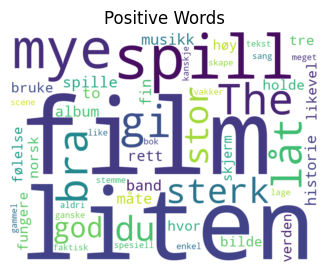

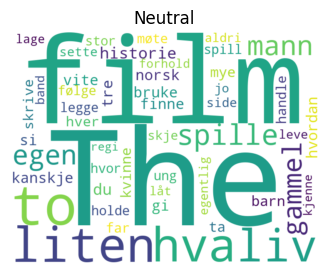

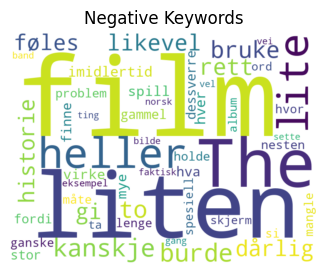

In [396]:
def generate_wordcloud(counter_obj, title):
    """Generate a word cloud using the given Counter object."""
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(counter_obj)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Assuming keyword_pos, keyword_neg, and keyword_neu are Counter objects containing the extracted keywords
# Generate Positive Word Cloud
generate_wordcloud(keyword_pos, "Positive Words")

# Generate Neutral Word Cloud
generate_wordcloud(keyword_neu, "Neutral")

# Generate Negative Word Cloud
generate_wordcloud(keyword_neg, "Negative Keywords")


In [397]:
# Assuming keyword_pos, keyword_neg, and keyword_neu are Counter objects containing the extracted keywords
total_pos_words = sum(keyword_pos.values())
total_neg_words = sum(keyword_neg.values())
total_neu_words = sum(keyword_neu.values())

In [398]:
sentiment_counts = [total_pos_words, total_neu_words, total_neg_words]
sentiment_labels = ['Positive', 'Neutral', 'Negative']

fig = go.Figure(go.Pie(labels=sentiment_labels, values=sentiment_counts))

fig.update_layout(
    title="Sentiment Distribution",
    height=600,
    width=800
)

fig.show()

## rewrite: use diagram above to explain why we remove. 
everything over the frequency of 40 is to be removed

We noticed that certain words in our data_train['cleaned_text'] may not be useful in determining whether a comment is positive, neutral, or negative. Hence, we have decided to manually remove some of the most frequently used words. We are using the .str.replace() function, where .str() searches for the given string in our text, and .replace() removes the specified string from our text. This step will further enhance the cleaning of our model.

In [399]:
# List of words to remove
words_to_remove = [
    'film', ' liten ', 'The', ' burde', ' kanskje', ' likevel', ' historie', ' du', ' ganske',
    ' heller', ' spill ', ' spille ', ' låt ', ' hva ', ' hvordan ', ' hver ', ' liv ',
    ' egen ', ' barn ', ' gi ', ' to ', ' måte ', ' norsk ', ' mann ', ' bruke ', ' musikk ',
    ' hvor '
]

# Replace each word in the list
for word in words_to_remove:
    data_train['text_cleaning'] = data_train['text_cleaning'].str.replace(word, '')

We create lists of words for each sentiment in our data_train based on the words in the "cleaned_text" column. We use the .tolist() function to transform every word in the text into a list. We do this for positive, negative and neutral sentiments, and name them pos_list, neg_list and neu_list. Then we concatenate every list of words into a single string by using the .join() function. After that, we use the "extract_keywords" function we created earlier to extract the most frequently used words in each sentiment's string and store them in a list, along with their frequency count. Then lastly we print the extracted words by using the print() function. This process helps us identify the most common words used in each sentiment, which can help us better understand the characteristics of positive, negative, and neutral comments in our data.

In [400]:
#Making a list 
pos_list = data_train[data_train["label"] == "Positive"]["text_cleaning"].tolist()
neg_list = data_train[data_train["label"] == "Negative"]["text_cleaning"].tolist()
neu_list = data_train[data_train["label"] == "Neutral"]["text_cleaning"].tolist()

#Positive Document
pos_doc = " ".join(pos_list)
print('Positive:',pos_doc)
#Neutral Document
neu_doc = " ".join(neu_list)
print('Neutral:', neu_doc)

#Negative Document
neg_doc = " ".join(neg_list)
print('Negative:',neg_doc)

#Extracting keywords
keyword_pos = key_extract(pos_doc)
keyword_neu = key_extract(neu_doc)
keyword_neg = key_extract(neg_doc)


print('Positive:',keyword_pos)
print('Neutral:',keyword_neu)
print('Negative:',keyword_neg)

Positive: bakside sort blank skinne deksel skjule kontakt kable betjening allsidig tilkoblingsvennlig skjerm knapp positiv overraske bildekvalitet spesiell fargedynamikk gjennomsnitt fast fargeprofil forskjellig temperatur velge manuell innstilling Justeringsområdet stor god tilpasningsmulighet forskjellig omgivelse praktisk spillsammenheng uproblematisk betraktningsvinkel side meget bra invitere 4 venn sitte skjerm side dårlig bilde skjerm spesiell betj bildekvalite gjennommsnitt  ta utfordring skikkelig behandling vanskelig mellommenneskelig forhold  Sideways About Schmidt vel regissør Alexander Payne si slags ekspert enorm oppleve intelligent skuespiller flink holde dog alltid tydelig foreta interessant beskrivelse Hawaii ofte beskrive paradis plan makte  underholde vise følelse interessant kunnskap  dessverre insistere unødvendig kompleksitet A Bite Out bra Action-scen bære femte Die hard - finnes verken engasjerende følsomhet elegant replikk far sønn McClane destruere Russland tid

We are now converting all the sentiment labels into numeric values since some models do not accept string inputs. To do this, we create by hand a replacement function that assigns a unique number to each sentiment label. We then apply this replacement function to every element of our data_train dataframe using the applymap(lambda x: label_to_numeric.get(x,x)) function. Here, applymap is a function that applies a function to every element of the dataframe, and label_to_numeric.get(x,x) retrieves the corresponding numeric value for a sentiment label, or returns the label itself if no matching value is found. We do the same process for our data_test and data_dev dataframes, and save the resulting dataframes with the suffix _data added to their original names.

In [401]:
#Into numeric
label_to_numerical = {
    'Neutral': 0,
    'Negative': -1,
    'Positive' : 1,
}

data_train_x =  data_train.applymap(lambda x: label_to_numerical.get(x, x))
data_test_x = data_test.applymap(lambda x: label_to_numerical.get(x, x))
data_dev_x = data_dev.applymap(lambda x: label_to_numerical.get(x, x))

We are splitting our data into subsets, which we will use for training and testing our model. We are assigning the training data to variables with names starting with "X" and the corresponding labels to variables with names starting with "y". For example, the training data will be assigned to "X_train" and the corresponding labels to "y_train".

In [402]:
#Train data
X_train = data_train_x['text_cleaning']
y_train = data_train_x['label']

#Dev data
X_val = data_dev_x['text_cleaning']
y_val = data_dev_x['label']

#Test data
X_test = data_test_x['text']
y_test = data_test_x['label']


Using sequential model, adding layers like activatiion relu and sigmoid to get predicted output

In [403]:
# Building model
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=17920))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

Optimizer using adam with learning rate, and a crossentropy loss function. The model is then compiled. We evaluate and train.

In [404]:
optimizer = Adam(learning_rate=0.01)
loss = categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

One hot encoding the the y values for training

In [405]:
#one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

Vectorization is the process of converting an algorithm from operating on a single value at a time to operating on a set of values (vector) at one time.

In [406]:
# instantiating CountVectorizer
vectorizer = CountVectorizer()

# fittinb and transforming the training data
X_train = vectorizer.fit_transform(data_train_x['text_cleaning'])

# transforming the validation and test data using the fitted vectorizer
X_val = vectorizer.transform(data_dev_x['text_cleaning'])
X_test = vectorizer.transform(data_test_x['text'])

# converting the sparse matrix into a numpy array
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

X_train.shape

(7973, 17920)

training the model

In [407]:
model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_val, y_val))

Epoch 1/10
798/798 [==============================] - 5s 6ms/step - loss: 0.9638 - accuracy: 0.5675 - val_loss: 0.9149 - val_accuracy: 0.5840
Epoch 2/10
798/798 [==============================] - 5s 7ms/step - loss: 0.7527 - accuracy: 0.6955 - val_loss: 0.9121 - val_accuracy: 0.5989
Epoch 3/10
798/798 [==============================] - 4s 5ms/step - loss: 0.5705 - accuracy: 0.7658 - val_loss: 1.1394 - val_accuracy: 0.6024
Epoch 4/10
798/798 [==============================] - 5s 6ms/step - loss: 0.4273 - accuracy: 0.8376 - val_loss: 1.2453 - val_accuracy: 0.5861
Epoch 5/10
798/798 [==============================] - 6s 8ms/step - loss: 0.3484 - accuracy: 0.8686 - val_loss: 1.4492 - val_accuracy: 0.5925
Epoch 6/10
798/798 [==============================] - 5s 7ms/step - loss: 0.2803 - accuracy: 0.9035 - val_loss: 1.7041 - val_accuracy: 0.5911
Epoch 7/10
798/798 [==============================] - 4s 5ms/step - loss: 0.2220 - accuracy: 0.9246 - val_loss: 1.7344 - val_accuracy: 0.5861
Epoch 

evaluating the x data and y data. predicting the max output to calculate the accuracy

In [408]:
# metrics
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test = np.argmax(y_test, axis=1)

report_test = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(report_test)

Accuracy: 51.48%
37/37 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

    Negative       0.57      0.78      0.66       598
     Neutral       0.54      0.22      0.31       401
    Positive       0.28      0.30      0.29       182

    accuracy                           0.51      1181
   macro avg       0.46      0.43      0.42      1181
weighted avg       0.51      0.51      0.48      1181



References: 

Bird, Steven, Edward Loper, and Ewan Klein. "Natural Language Processing with Python." O'Reilly Media, Inc., 2009.

Introduction to Machine Learning with Python by Andreas Müller and Sarah Guido

Sentdex. "Natural Language Processing With Python and NLTK p.1 Tokenizing words and Sentences." YouTube, 27 October 2016, https://www.youtube.com/watch?v=hQYDmHr3qt8.

Tech with Tim. "Python Sentiment Analysis Tutorial (Text Classification Using Naive Bayes)." YouTube, 22 June 2020, https://www.youtube.com/watch?v=VAMKuRAh2nc&list=RDCMUCTiWgVtEGSY4cuduJbMPblA&index=4.

PyTorch. "Neural Networks." YouTube, 31 January 2018, https://www.youtube.com/watch?v=cd51nXNpiiU.

MonkeyLearn. "Sentiment Analysis: A Definitive Guide." MonkeyLearn Blog, 7 September 2021, https://monkeylearn.com/sentiment-analysis/.
